# Starbucks Capstone Challenge

### Introduction

This data set contains simulated data that mimics customer behavior on the Starbucks rewards mobile app. Once every few days, Starbucks sends out an offer to users of the mobile app. An offer can be merely an advertisement for a drink or an actual offer such as a discount or BOGO (buy one get one free). Some users might not receive any offer during certain weeks. 

Not all users receive the same offer, and that is the challenge to solve with this data set.

Your task is to combine transaction, demographic and offer data to determine which demographic groups respond best to which offer type. This data set is a simplified version of the real Starbucks app because the underlying simulator only has one product whereas Starbucks actually sells dozens of products.

Every offer has a validity period before the offer expires. As an example, a BOGO offer might be valid for only 5 days. You'll see in the data set that informational offers have a validity period even though these ads are merely providing information about a product; for example, if an informational offer has 7 days of validity, you can assume the customer is feeling the influence of the offer for 7 days after receiving the advertisement.

You'll be given transactional data showing user purchases made on the app including the timestamp of purchase and the amount of money spent on a purchase. This transactional data also has a record for each offer that a user receives as well as a record for when a user actually views the offer. There are also records for when a user completes an offer. 

Keep in mind as well that someone using the app might make a purchase through the app without having received an offer or seen an offer.

### Example

To give an example, a user could receive a discount offer buy 10 dollars get 2 off on Monday. The offer is valid for 10 days from receipt. If the customer accumulates at least 10 dollars in purchases during the validity period, the customer completes the offer.

However, there are a few things to watch out for in this data set. Customers do not opt into the offers that they receive; in other words, a user can receive an offer, never actually view the offer, and still complete the offer. For example, a user might receive the "buy 10 dollars get 2 dollars off offer", but the user never opens the offer during the 10 day validity period. The customer spends 15 dollars during those ten days. There will be an offer completion record in the data set; however, the customer was not influenced by the offer because the customer never viewed the offer.

### Cleaning

This makes data cleaning especially important and tricky.

You'll also want to take into account that some demographic groups will make purchases even if they don't receive an offer. From a business perspective, if a customer is going to make a 10 dollar purchase without an offer anyway, you wouldn't want to send a buy 10 dollars get 2 dollars off offer. You'll want to try to assess what a certain demographic group will buy when not receiving any offers.

### Final Advice

Because this is a capstone project, you are free to analyze the data any way you see fit. For example, you could build a machine learning model that predicts how much someone will spend based on demographics and offer type. Or you could build a model that predicts whether or not someone will respond to an offer. Or, you don't need to build a machine learning model at all. You could develop a set of heuristics that determine what offer you should send to each customer (i.e., 75 percent of women customers who were 35 years old responded to offer A vs 40 percent from the same demographic to offer B, so send offer A).

# Data Sets

The data is contained in three files:

* portfolio.json - containing offer ids and meta data about each offer (duration, type, etc.)
* profile.json - demographic data for each customer
* transcript.json - records for transactions, offers received, offers viewed, and offers completed

Here is the schema and explanation of each variable in the files:

**portfolio.json**
* id (string) - offer id
* offer_type (string) - type of offer ie BOGO, discount, informational
* difficulty (int) - minimum required spend to complete an offer
* reward (int) - reward given for completing an offer
* duration (int) - time for offer to be open, in days
* channels (list of strings)

**profile.json**
* age (int) - age of the customer 
* became_member_on (int) - date when customer created an app account
* gender (str) - gender of the customer (note some entries contain 'O' for other rather than M or F)
* id (str) - customer id
* income (float) - customer's income

**transcript.json**
* event (str) - record description (ie transaction, offer received, offer viewed, etc.)
* person (str) - customer id
* time (int) - time in hours since start of test. The data begins at time t=0
* value - (dict of strings) - either an offer id or transaction amount depending on the record

**Note:** If you are using the workspace, you will need to go to the terminal and run the command `conda update pandas` before reading in the files. This is because the version of pandas in the workspace cannot read in the transcript.json file correctly, but the newest version of pandas can. You can access the termnal from the orange icon in the top left of this notebook.  

You can see how to access the terminal and how the install works using the two images below.  First you need to access the terminal:

<img src="pic1.png"/>

Then you will want to run the above command:

<img src="pic2.png"/>

Finally, when you enter back into the notebook (use the jupyter icon again), you should be able to run the below cell without any errors.

In [2]:
import pandas as pd
import numpy as np
import math
import json
% matplotlib inline
import matplotlib.pyplot as plt
import datetime
import seaborn as sns

# read in the json files
portfolio = pd.read_json('data/portfolio.json', orient='records', lines=True)
profile = pd.read_json('data/profile.json', orient='records', lines=True)
transcript = pd.read_json('data/transcript.json', orient='records', lines=True)

In [3]:
portfolio.head()

,channels,difficulty,duration,id,offer_type,reward
0,"[email, mobile, social]",10,7,ae264e3637204a6fb9bb56bc8210ddfd,bogo,10
1,"[web, email, mobile, social]",10,5,4d5c57ea9a6940dd891ad53e9dbe8da0,bogo,10
2,"[web, email, mobile]",0,4,3f207df678b143eea3cee63160fa8bed,informational,0
3,"[web, email, mobile]",5,7,9b98b8c7a33c4b65b9aebfe6a799e6d9,bogo,5
4,"[web, email]",20,10,0b1e1539f2cc45b7b9fa7c272da2e1d7,discount,5


In [4]:
profile.head()

,age,became_member_on,gender,id,income
0,118,20170212,None,68be06ca386d4c31939f3a4f0e3dd783,NaN
1,55,20170715,F,0610b486422d4921ae7d2bf64640c50b,112000.0
2,118,20180712,None,38fe809add3b4fcf9315a9694bb96ff5,NaN
3,75,20170509,F,78afa995795e4d85b5d9ceeca43f5fef,100000.0
4,118,20170804,None,a03223e636434f42ac4c3df47e8bac43,NaN


In [6]:
transcript.head()

,event,person,time,value
0,offer received,78afa995795e4d85b5d9ceeca43f5fef,0,{'offer id': '9b98b8c7a33c4b65b9aebfe6a799e6d9'}
1,offer received,a03223e636434f42ac4c3df47e8bac43,0,{'offer id': '0b1e1539f2cc45b7b9fa7c272da2e1d7'}
2,offer received,e2127556f4f64592b11af22de27a7932,0,{'offer id': '2906b810c7d4411798c6938adc9daaa5'}
3,offer received,8ec6ce2a7e7949b1bf142def7d0e0586,0,{'offer id': 'fafdcd668e3743c1bb461111dcafc2a4'}
4,offer received,68617ca6246f4fbc85e91a2a49552598,0,{'offer id': '4d5c57ea9a6940dd891ad53e9dbe8da0'}


# portfolio clean up

In [7]:
available_channels = []

# Look to see what are all of the different channels
for channel in portfolio['channels']:
    for t in channel:
        if t not in available_channels:
            available_channels.append(t)
            
available_channels

['email', 'mobile', 'social', 'web']

In [8]:
# Add in the email, mobile, social, and web columns
for channel in available_channels:
    portfolio[channel] = portfolio['channels'].apply(lambda x: 1 if channel in x else 0)  

portfolio.drop('channels', axis = 1, inplace=True) # No longer need the channels column

# Make Sure all of the int and float columns are correct
cols_to_update = ['difficulty', 'duration','reward']

for col in cols_to_update:
    portfolio[col] = portfolio[col].apply(lambda x: int(x))


portfolio.head()

,difficulty,duration,id,offer_type,reward,email,mobile,social,web
0,10,7,ae264e3637204a6fb9bb56bc8210ddfd,bogo,10,1,1,1,0
1,10,5,4d5c57ea9a6940dd891ad53e9dbe8da0,bogo,10,1,1,1,1
2,0,4,3f207df678b143eea3cee63160fa8bed,informational,0,1,1,0,1
3,5,7,9b98b8c7a33c4b65b9aebfe6a799e6d9,bogo,5,1,1,0,1
4,20,10,0b1e1539f2cc45b7b9fa7c272da2e1d7,discount,5,1,0,0,1


In [9]:
# Make sure that each row is unique
len(np.unique(portfolio['id'])) == len(portfolio)

True

# transcript clean up

In [10]:
transcript['value_type'] = transcript['value'].apply(lambda x: list(x.keys())[0]) # First value is the value_type
transcript['value'] = transcript['value'].apply(lambda x: list(x.values())[0]) # Second value is the new value

# Make sure that the time value is an integer amount
transcript['time'] = transcript['time'].apply(lambda x: int(x))

transcript.head()

,event,person,time,value,value_type
0,offer received,78afa995795e4d85b5d9ceeca43f5fef,0,9b98b8c7a33c4b65b9aebfe6a799e6d9,offer id
1,offer received,a03223e636434f42ac4c3df47e8bac43,0,0b1e1539f2cc45b7b9fa7c272da2e1d7,offer id
2,offer received,e2127556f4f64592b11af22de27a7932,0,2906b810c7d4411798c6938adc9daaa5,offer id
3,offer received,8ec6ce2a7e7949b1bf142def7d0e0586,0,fafdcd668e3743c1bb461111dcafc2a4,offer id
4,offer received,68617ca6246f4fbc85e91a2a49552598,0,4d5c57ea9a6940dd891ad53e9dbe8da0,offer id


# profile cleanup

In [11]:
# For Gender, instead of assuming a gender, lets just make the gender Unknown
profile['gender'].fillna('U', inplace = True)
profile['income'] = profile['income'].apply(lambda x: float(x))
profile['age'] = profile['age'].apply(lambda x: int(x))

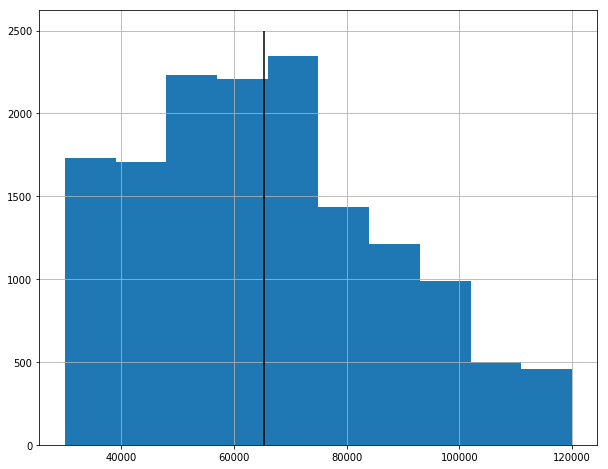

In [12]:
# What should be filled in for the null 
# The mean looks like it would be apropraiate in this distribution
profile.income.hist(bins=10, figsize=(10,8));
plt.vlines(profile.income.mean(), 0, 2500); # Show where the mean is in the 

In [13]:
mean_val = profile.income.mean() # 65404.99
profile['income'].fillna(mean_val, inplace = True)

In [14]:
# Converting became_member_on to an actual date number and also creating more
# columns based on the year, month, daay for further analysis
profile['member_year'] = profile.became_member_on.apply(lambda x: int(str(x)[:4]))
profile['member_month'] = profile.became_member_on.apply(lambda x: int(str(x)[4:6]))
profile['member_day'] = profile.became_member_on.apply(lambda x: int(str(x)[6:]))
profile['member_date'] = profile.became_member_on.apply(lambda x: datetime.datetime.strptime(str(x), '%Y%m%d'))
profile.drop('became_member_on', axis = 1, inplace = True)

In [15]:
profile.head()

,age,gender,id,income,member_year,member_month,member_day,member_date
0,118,U,68be06ca386d4c31939f3a4f0e3dd783,65404.991568,2017,2,12,2017-02-12
1,55,F,0610b486422d4921ae7d2bf64640c50b,112000.000000,2017,7,15,2017-07-15
2,118,U,38fe809add3b4fcf9315a9694bb96ff5,65404.991568,2018,7,12,2018-07-12
3,75,F,78afa995795e4d85b5d9ceeca43f5fef,100000.000000,2017,5,9,2017-05-09
4,118,U,a03223e636434f42ac4c3df47e8bac43,65404.991568,2017,8,4,2017-08-04


# Exploratory Analysis

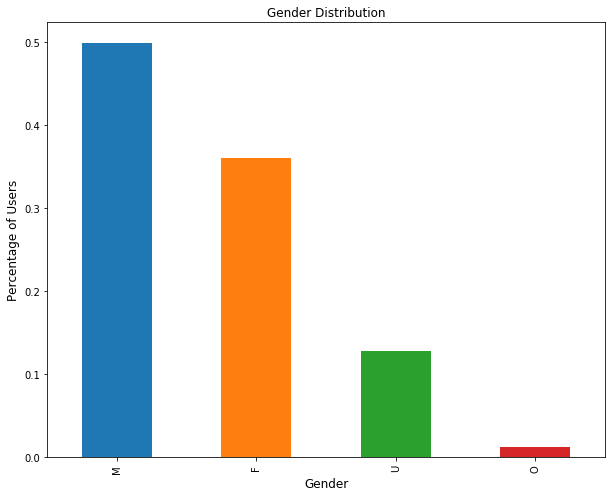

In [16]:
profile.gender.value_counts(normalize=True).plot('bar', figsize = (10,8))
plt.title('Gender Distribution')
plt.ylabel('Percentage of Users', fontsize = 12)
plt.xlabel('Gender', fontsize = 12);

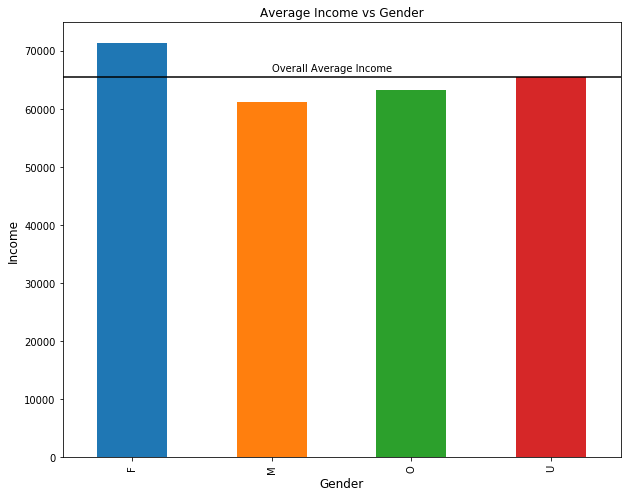

In [17]:
gender_income = profile.groupby('gender', as_index=False).agg({'income':'mean'})
gender_income.plot(kind = 'bar', x = 'gender', y = 'income', legend=False, figsize=(10,8))
plt.hlines(mean_val, -100 , 1000)
plt.ylabel('Income', fontsize = 12)
plt.xlabel('Gender', fontsize = 12)
plt.title('Average Income vs Gender')
plt.text(1, mean_val + 1000, 'Overall Average Income'); 

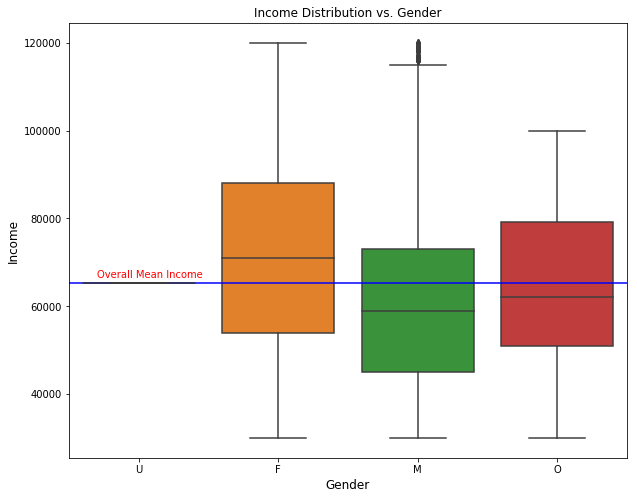

In [18]:
plt.figure(figsize=(10,8))
sns.boxplot(x = 'gender', y = 'income', data = profile)
plt.hlines(mean_val, -100 , 1000, color = 'b')
plt.ylabel('Income', fontsize = 12)
plt.xlabel('Gender', fontsize = 12)
plt.title('Income Distribution vs. Gender')
plt.text(x = -.3, y = mean_val + 1000, s = "Overall Mean Income", color = 'r');

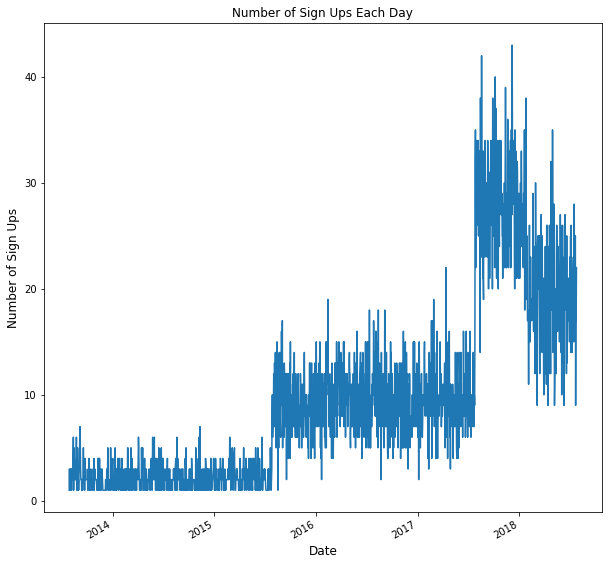

In [19]:
# Number of sign ups each day
profile.member_date.value_counts().plot(kind = 'line', figsize = (10,10))
plt.xlabel('Date', fontsize = 12)
plt.ylabel('Number of Sign Ups', fontsize = 12)
plt.title('Number of Sign Ups Each Day');

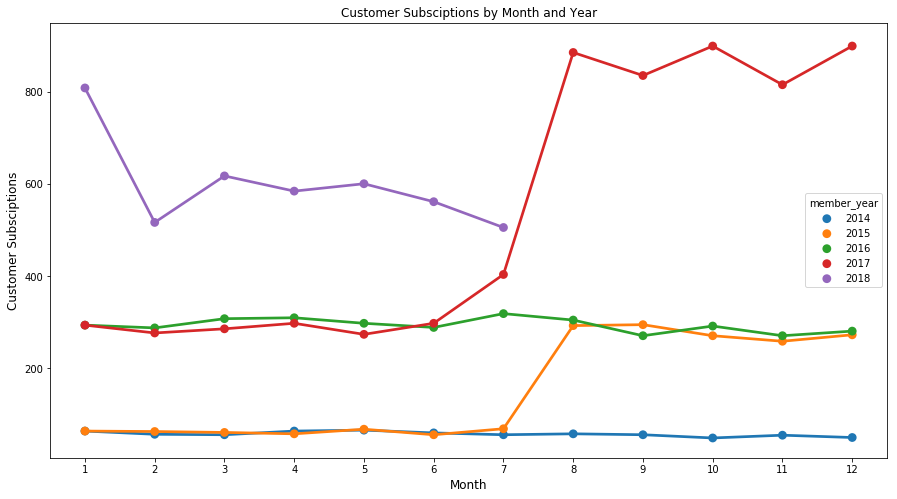

In [20]:
membership_subs = profile[profile['member_year'] >= 2014].groupby(['member_year','member_month'], as_index=False).agg({'id':'count'})
plt.figure(figsize=(15,8))
sns.pointplot(x="member_month", y="id", hue="member_year", data = membership_subs)
plt.ylabel('Customer Subsciptions', fontsize = 12)
plt.xlabel('Month', fontsize = 12)
plt.title('Customer Subsciptions by Month and Year');

In [21]:
# This specific one is a discount offer that was recieved, viewed, and completed all on the same day
transcript[(transcript['person'] == '9fa9ae8f57894cc9a3b8a9bbe0fc1b2f') 
           & (transcript['value'] == '2906b810c7d4411798c6938adc9daaa5')]

,event,person,time,value,value_type
36,offer received,9fa9ae8f57894cc9a3b8a9bbe0fc1b2f,0,2906b810c7d4411798c6938adc9daaa5,offer id
12656,offer viewed,9fa9ae8f57894cc9a3b8a9bbe0fc1b2f,0,2906b810c7d4411798c6938adc9daaa5,offer id
12658,offer completed,9fa9ae8f57894cc9a3b8a9bbe0fc1b2f,0,2906b810c7d4411798c6938adc9daaa5,offer_id


In [22]:
portfolio[portfolio['id'] == '2906b810c7d4411798c6938adc9daaa5']

,difficulty,duration,id,offer_type,reward,email,mobile,social,web
9,10,7,2906b810c7d4411798c6938adc9daaa5,discount,2,1,1,0,1


In [23]:
# The different events that come through are mostly transactions, then apropriately the offers recieved, 
# offers viewed, and offers completed.
transcript['event'].value_counts(normalize = True)

transaction        0.453304
offer received     0.248837
offer viewed       0.188315
offer completed    0.109544
Name: event, dtype: float64

In [24]:
# Looking at all of the completed offers, discounts and bogos are roughly a 50/50 split. 
trans_and_offers = pd.merge(transcript[(transcript['value_type'] == 'offer_id') & (transcript['event'] == 'offer completed')]
                            , portfolio, how = 'inner', left_on = 'value', right_on = 'id')
trans_and_offers['offer_type'].value_counts(normalize = True)

discount    0.533369
bogo        0.466631
Name: offer_type, dtype: float64

In [25]:
# All amount transactions of a random person
test_person_transactions = transcript[(transcript['person'] == '8dbfa485249f409aa223a2130f40634a')
          & (transcript['value_type'] == 'amount')].reset_index()
# Get the difference of days between purchases
test_person_transactions['DaysFromLastPurchase'] = test_person_transactions.time.diff()

# The first value needs to be the same as the first transaction time inseat of NULL
test_person_transactions.iloc[0, -1] = test_person_transactions.loc[0, 'time']

# Need to set values as an float

test_person_transactions['value'] = test_person_transactions['value'].apply(lambda x: float(x))

# Don't need the reset index column anymore
test_person_transactions.drop('index', axis = 1, inplace = True)
test_person_transactions.head(10)

,event,person,time,value,value_type,DaysFromLastPurchase
0,transaction,8dbfa485249f409aa223a2130f40634a,6,3.86,amount,6.0
1,transaction,8dbfa485249f409aa223a2130f40634a,30,0.88,amount,24.0
2,transaction,8dbfa485249f409aa223a2130f40634a,36,2.86,amount,6.0
3,transaction,8dbfa485249f409aa223a2130f40634a,54,0.17,amount,18.0
4,transaction,8dbfa485249f409aa223a2130f40634a,78,1.02,amount,24.0
5,transaction,8dbfa485249f409aa223a2130f40634a,84,0.49,amount,6.0
6,transaction,8dbfa485249f409aa223a2130f40634a,108,1.72,amount,24.0
7,transaction,8dbfa485249f409aa223a2130f40634a,186,1.66,amount,78.0
8,transaction,8dbfa485249f409aa223a2130f40634a,192,0.61,amount,6.0
9,transaction,8dbfa485249f409aa223a2130f40634a,228,1.31,amount,36.0


In [26]:
# Now we can aggregate the values to get the average transaction amount, average days between purchases,
# and how long that they have been a customer
test_person_transactions.groupby('person').agg({
                                                'value':'mean' #Average transaction Amount
                                               , 'DaysFromLastPurchase':'mean' #Average days between purchases
                                                , 'time':'max' # How long they have been a Starbucks member
                                               })

,value,DaysFromLastPurchase,time
person,,,
8dbfa485249f409aa223a2130f40634a,2.123889,18.833333,678


In [27]:
# Want to look at recieved transactions and completed transactions
test_completion = pd.merge(
                    transcript[transcript['event'] == 'offer received']
                    , transcript[transcript['event'] == 'offer completed']
                    , how = 'left'
                    , left_on = ['person','value']
                    , right_on = ['person','value']
        )

# Make sure that the time values are converted to floats / integers
test_completion['time_y'] = test_completion['time_y'].apply(lambda x: float(x))
test_completion['time_x'] = test_completion['time_x'].apply(lambda x: float(x))

In [28]:
test_completion.head()

,event_x,person,time_x,value,value_type_x,event_y,time_y,value_type_y
0,offer received,78afa995795e4d85b5d9ceeca43f5fef,0.0,9b98b8c7a33c4b65b9aebfe6a799e6d9,offer id,offer completed,132.0,offer_id
1,offer received,a03223e636434f42ac4c3df47e8bac43,0.0,0b1e1539f2cc45b7b9fa7c272da2e1d7,offer id,NaN,NaN,NaN
2,offer received,e2127556f4f64592b11af22de27a7932,0.0,2906b810c7d4411798c6938adc9daaa5,offer id,NaN,NaN,NaN
3,offer received,8ec6ce2a7e7949b1bf142def7d0e0586,0.0,fafdcd668e3743c1bb461111dcafc2a4,offer id,NaN,NaN,NaN
4,offer received,68617ca6246f4fbc85e91a2a49552598,0.0,4d5c57ea9a6940dd891ad53e9dbe8da0,offer id,NaN,NaN,NaN


In [29]:
completion = test_completion[
    (
        (test_completion['time_y'] <= (test_completion['time_x'] + 20)) # Completion date is within max time frame
        & (test_completion['time_y'] >= test_completion['time_x'])  # Completion date is after offer received
    )
    
    | # or 
    
    (pd.isnull(test_completion['event_y']) == True) # Null values to show offers that were never completed
        ][['person','time_x','value','event_y','time_y']]

completion['DaysToCompleteOffer'] = completion['time_y'] - completion['time_x'] 
completion['CompletedOffer'] = completion['event_y'].apply(lambda x: 0 if pd.isnull(x) == True else 1)
completion.tail()

,person,time_x,value,event_y,time_y,DaysToCompleteOffer,CompletedOffer
86425,f924927e7f844ecebf87eef93f4d2688,576.0,5a8bc65990b245e5a138643cd4eb9837,NaN,NaN,NaN,0
86426,a57890c3bbb7463e9018abb7fecadb15,576.0,5a8bc65990b245e5a138643cd4eb9837,NaN,NaN,NaN,0
86429,6d5f3a774f3d4714ab0c092238f3a1d7,576.0,2298d6c36e964ae4a3e7e9706d1fb8c2,NaN,NaN,NaN,0
86430,9dc1421481194dcd9400aec7c9ae6366,576.0,ae264e3637204a6fb9bb56bc8210ddfd,offer completed,594.0,18.0,1
86431,e4052622e5ba45a8b96b59aba68cf068,576.0,3f207df678b143eea3cee63160fa8bed,NaN,NaN,NaN,0


In [30]:
completion[completion['person'] == '8dbfa485249f409aa223a2130f40634a']

,person,time_x,value,event_y,time_y,DaysToCompleteOffer,CompletedOffer
5765,8dbfa485249f409aa223a2130f40634a,0.0,4d5c57ea9a6940dd891ad53e9dbe8da0,NaN,NaN,NaN,0
63399,8dbfa485249f409aa223a2130f40634a,504.0,ae264e3637204a6fb9bb56bc8210ddfd,NaN,NaN,NaN,0


In [31]:
# We can see that this person completed both 
completion[completion['person'] == '9dc1421481194dcd9400aec7c9ae6366']

,person,time_x,value,event_y,time_y,DaysToCompleteOffer,CompletedOffer
57550,9dc1421481194dcd9400aec7c9ae6366,408.0,9b98b8c7a33c4b65b9aebfe6a799e6d9,offer completed,414.0,6.0,1
86430,9dc1421481194dcd9400aec7c9ae6366,576.0,ae264e3637204a6fb9bb56bc8210ddfd,offer completed,594.0,18.0,1


In [32]:
completion[completion['person'] == '9dc1421481194dcd9400aec7c9ae6366'].groupby('person').agg({
    
    'time_x':'min' # When they recieved their first offer
    , 'CompletedOffer': 'mean' # Percentage of Completed Offers
    , 'DaysToCompleteOffer': 'mean' # Average time it takes to complete an offer
})

,time_x,CompletedOffer,DaysToCompleteOffer
person,,,
9dc1421481194dcd9400aec7c9ae6366,408.0,1,12.0


In [33]:
# Bring together the completed / non completed offers and what type of offer they were
offers_final_df = pd.merge(completion
         ,portfolio
         , how = 'inner'
         , left_on = 'value'
         , right_on = 'id'
        )[['person','time_x','value','CompletedOffer','DaysToCompleteOffer'
          , 'difficulty','duration','offer_type','reward','email','mobile','social','web'
          ]]
offers_final_df.columns = ['person','offer_time','value','CompletedOffer','DaysToCompleteOffer'
                          ,'difficulty','duration','offer_type','reward'
                          , 'email','mobile','social','web'
                        ]
offers_final_df['NetReward'] = offers_final_df['reward'] - offers_final_df['difficulty']
offers_final_df.tail()

,person,offer_time,value,CompletedOffer,DaysToCompleteOffer,difficulty,duration,offer_type,reward,email,mobile,social,web,NetReward
48845,db1805ed333844978e8b46ed3e4643ae,576.0,f19421c1d4aa40978ebb69ca19b0e20d,0,NaN,5,5,bogo,5,1,1,1,1,0
48846,eec70ab28af74a22a4aeb889c0317944,576.0,f19421c1d4aa40978ebb69ca19b0e20d,1,18.0,5,5,bogo,5,1,1,1,1,0
48847,31e915c24163436790b97c1d45b545f6,576.0,f19421c1d4aa40978ebb69ca19b0e20d,1,18.0,5,5,bogo,5,1,1,1,1,0
48848,361539b15a6243dc834c6b25e481570b,576.0,f19421c1d4aa40978ebb69ca19b0e20d,0,NaN,5,5,bogo,5,1,1,1,1,0
48849,eb7dd979f4644052a5c401a01f129132,576.0,f19421c1d4aa40978ebb69ca19b0e20d,0,NaN,5,5,bogo,5,1,1,1,1,0


In [34]:
overall_offers_df = offers_final_df.groupby(['offer_type','difficulty','reward'], as_index = False).agg({
    'CompletedOffer':['mean', 'sum'] # Average of time they complete the order
    , 'DaysToCompleteOffer':'mean' # Average days it takes for someone to complete the order
    , 'NetReward': 'max' # The net reward (should be just the reward - difficulty)
})

overall_offers_df.columns.droplevel(1)
overall_offers_df.columns = ['offer_type','difficulty','reward','CompletedOffers','TotalCompletions'
                            , 'AvgDaysToComplete','NetReward']
overall_offers_df['NetWorth'] = (overall_offers_df['CompletedOffers'] * overall_offers_df['NetReward']) * -1
final_overall_offers_df = overall_offers_df[overall_offers_df['offer_type'] != 'informational']
final_overall_offers_df

,offer_type,difficulty,reward,CompletedOffers,TotalCompletions,AvgDaysToComplete,NetReward,NetWorth
0,bogo,5,5,0.308293,2606,8.638526,0,-0.000000
1,bogo,10,10,0.217532,2149,9.001396,0,-0.000000
2,discount,7,3,0.383878,1362,8.938326,-4,1.535513
3,discount,10,2,0.279512,2060,8.906796,-8,2.236092
4,discount,20,5,0.090034,393,9.511450,-15,1.350515


In [35]:
all_transactions = transcript[transcript['value_type'] == 'amount']
all_transactions['value'] = all_transactions['value'].apply(lambda x: float(x))
all_transactions.head()

/opt/conda/lib/python3.6/site-packages/ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  


,event,person,time,value,value_type
12654,transaction,02c083884c7d45b39cc68e1314fec56c,0,0.83,amount
12657,transaction,9fa9ae8f57894cc9a3b8a9bbe0fc1b2f,0,34.56,amount
12659,transaction,54890f68699049c2a04d415abc25e717,0,13.23,amount
12670,transaction,b2f1cd155b864803ad8334cdf13c4bd2,0,19.51,amount
12671,transaction,fe97aa22dd3e48c8b143116a8403dd52,0,18.97,amount


In [36]:
df_all_customers = pd.DataFrame(columns = ['person', 'discount_total_offers', 'discount_completion_pct',
       'discount_min_completion_days', 'discount_max_completion_days', 'discount_completed_offers',
       'discount_avg_completion_days', 'discount_avg_net_reward',
       'bogo_total_offers', 'bogo_completion_pct', 'bogo_completed_offers' 'bogo_min_completion_days',
       'bogo_max_completion_days', 'bogo_avg_completion_days',
       'bogo_avg_net_reward', 'informational_promotions', 'age', 'gender',
       'income', 'member_date', 'total_transactions', 'min_transaction_day',
       'max_transaction_day', 'avg_transaction', 'total_transaction_amount',
       'median_days_between_purchases', 'avg_days_between_purchases'])

for person in np.unique(profile['id']):
    
    # Get Individual profile info
    personal_profile = profile[profile['id'] == person][['id','age','gender','income','member_date']]
    
    # Get transaction aggregates
    personal_transactions = all_transactions[all_transactions['person'] == person].reset_index()
    if len(personal_transactions) > 0:
        personal_transactions['DaysFromLastPurchase'] = personal_transactions.time.diff()
        personal_transactions.iloc[0, -1] = test_person_transactions.loc[0, 'time']

        personal_agg_trans = personal_transactions.groupby('person', as_index = False).agg(
        {
            'time': ['count','min','max'] # First and Last Purchase
            , 'value': ['mean', 'sum'] # Average Purchase Amount, total purchase amount
            , 'DaysFromLastPurchase': ['median', 'mean'] # Average days between purchases  
        })
        personal_agg_trans.columns = personal_agg_trans.columns.droplevel(1) # Gets rid of the multi leveling columns
        personal_agg_trans.columns = ['person', 'total_transactions','min_transaction_day','max_transaction_day'
                                      , 'avg_transaction','total_transaction_amount','median_days_between_purchases'
                                      ,'avg_days_between_purchases']
    else:
        null_array = [person, np.nan, np.nan, np.nan, np.nan, np.nan, np.nan]
        personal_agg_trans = pd.DataFrame([null_array]
                                         , columns = ['person', 'total_transactions','min_transaction_day'
                                                      ,'max_transaction_day'
                                                      , 'avg_transaction','median_days_between_purchases'
                                                      ,'avg_days_between_purchases'])
        
        
    # Bring together the transaction aggregates and the profile values
    personal_df_1 = pd.merge(personal_profile, personal_agg_trans
                             , how = 'inner', left_on = 'id', right_on = 'person')
    personal_df_1.drop('id', axis = 1, inplace = True) # Get rid of the ID column
    
    
    # Look at the different promotions that the person interacted with
    # Using global variables to join data in the next step
    for offer_type in ['discount','bogo']:
        globals()[offer_type + '_df'] =  offers_final_df[(offers_final_df['person'] == person)
                       & (offers_final_df['offer_type'] == offer_type)
                       ].groupby('person', as_index = False).agg({
                                                        'CompletedOffer':['count','mean','sum']
                                                        , 'DaysToCompleteOffer': ['min','max','mean']
                                                        , 'NetReward': ['mean']
                                                    })
        
        globals()[offer_type + '_df'].columns = globals()[offer_type + '_df'].columns.droplevel(1)
        globals()[offer_type + '_df'].columns = ['person', offer_type + '_total_offers'
                                    ,offer_type + '_completion_pct', offer_type + '_completed_offers'
                                   , offer_type + '_min_completion_days',offer_type + '_max_completion_days'
                                    ,offer_type + '_avg_completion_days', offer_type + '_avg_net_reward']
        
        if len(globals()[offer_type + '_df']) == 0:
            null_array = [person,np.nan,np.nan,np.nan,np.nan,np.nan,np.nan, np.nan]
            globals()[offer_type + '_df'] = globals()[offer_type + '_df'].append(
                dict(zip(globals()[offer_type + '_df'].columns, null_array)), ignore_index=True
            )
    
    # Bring together the bogo and discount values, and include the number of informational promos they received
    bogo_and_discounts = pd.merge(discount_df, bogo_df)
    bogo_and_discounts['informational_promotions'] = len(offers_final_df[(offers_final_df['person'] == person)
                                                               & (offers_final_df['offer_type'] == 'informational')])
    
    # Bring everything together
    person_final = pd.merge(bogo_and_discounts, personal_df_1)
    
    # Add personal df to the rest of the customer dataframe
    df_all_customers = df_all_customers.append(person_final)
        

/opt/conda/lib/python3.6/site-packages/pandas/core/frame.py:6211: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.

  sort=sort)


ValueError: minlength must be positive